**UNR - TUIA**

# Trabajo Prático N°: 2 - Aprendizaje Automático

### Integrantes:
*   Crenna, Giuliano. Legajo: C-7438/1.
*   Pace, Bruno. Legajo: P-5295/7.
*   Sancho Almenar, Mariano. Legajo: S-5778/9.

In [2]:
#Tratamiento de datos:
import numpy as np
import pandas as pd

#Gráficos:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#Preprocesado y modelado:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, ElasticNetCV, LassoCV, SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
import random

from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier


#Configuración de warnings:
import warnings
warnings.filterwarnings('ignore')

## Lectura y separación de DF


In [3]:
df: pd.DataFrame = pd.read_csv('weatherAUS.csv')

Ejecutamos un random sobre las ubicaciones para quedarnos con 10. Esto va a cambiar con las ejecuciones, por eso se creó la lista estatica "choosen_cities"

In [4]:
random.sample(df['Location'].unique().tolist(), k=10)

['Richmond',
 'Nuriootpa',
 'Tuggeranong',
 'Sydney',
 'CoffsHarbour',
 'AliceSprings',
 'Albany',
 'Melbourne',
 'Ballarat',
 'Penrith']

In [5]:
choosen_cities: list[str] =  ['NorfolkIsland',
 'Richmond',
 'Sydney',
 'Nhil',
 'Canberra',
 'GoldCoast',
 'Darwin',
 'NorahHead',
 'MountGambier',
 'WaggaWagga']

In [6]:
selected_df: pd.DataFrame = df[df['Location'].isin(choosen_cities)] #filtro por ubicaciones seleccionadas

observamos el df filtrado

In [7]:
selected_df.sample(5)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
139216,2008-10-14,Darwin,26.5,34.8,0.0,7.6,8.1,N,41.0,NNW,...,62.0,54.0,1012.5,1008.4,4.0,5.0,30.5,32.6,No,Yes
19975,2014-05-09,NorahHead,12.4,20.6,28.4,NaN,NaN,N,24.0,WSW,...,91.0,73.0,1026.3,1023.6,NaN,NaN,14.7,18.6,Yes,No
21926,2011-03-19,NorfolkIsland,18.2,23.9,0.0,4.6,0.5,ESE,44.0,ESE,...,80.0,78.0,1016.9,1014.9,7.0,7.0,23.0,22.7,No,Yes
20990,2017-02-17,NorahHead,21.7,28.5,0.0,NaN,NaN,S,57.0,NNE,...,89.0,84.0,1010.3,1006.1,NaN,NaN,24.1,23.5,No,Yes
74077,2015-01-05,Nhil,11.9,35.3,0.0,NaN,NaN,SSE,43.0,SE,...,34.0,23.0,1017.6,1015.7,NaN,NaN,21.5,32.2,No,No


Divido el df sobre la selección hecha

In [8]:
X: pd.DataFrame = selected_df.drop(columns='RainTomorrow')
y: pd.DataFrame = selected_df[['RainTomorrow']] #Variable a predecir

Separación test y train conforme a las convenciones del 80% para Train y 20% para test.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

## Visualización de datos y manejo de valores faltantes

Vemos que hay una variable "Yes/No" en RainToday. La convertimos a Dummy.

In [10]:
def getting_dummy(string_: str) -> int:
    return 1 if string_ == 'Yes' else 0

In [11]:
X_train['RainToday'] = X_train['RainToday'].apply(getting_dummy)

In [12]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23729 entries, 27774 to 99738
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           23729 non-null  object 
 1   Location       23729 non-null  object 
 2   MinTemp        23666 non-null  float64
 3   MaxTemp        23674 non-null  float64
 4   Rainfall       23480 non-null  float64
 5   Evaporation    14484 non-null  float64
 6   Sunshine       12568 non-null  float64
 7   WindGustDir    22299 non-null  object 
 8   WindGustSpeed  22305 non-null  float64
 9   WindDir9am     22187 non-null  object 
 10  WindDir3pm     23310 non-null  object 
 11  WindSpeed9am   23404 non-null  float64
 12  WindSpeed3pm   23424 non-null  float64
 13  Humidity9am    23549 non-null  float64
 14  Humidity3pm    23604 non-null  float64
 15  Pressure9am    23461 non-null  float64
 16  Pressure3pm    23470 non-null  float64
 17  Cloud9am       14045 non-null  float64
 18  Cloud3p

## Analisis de balance

In [65]:
location_values: pd.Series = pd.value_counts(X_train['Location'], sort=True)
print(location_values)

Location
Canberra         2768
Sydney           2666
Darwin           2556
GoldCoast        2435
NorahHead        2433
NorfolkIsland    2412
Richmond         2402
WaggaWagga       2394
MountGambier     2389
Nhil             1274
Name: count, dtype: int64


Text(0.5, 1.0, 'Cantidad de datos por ubicación')

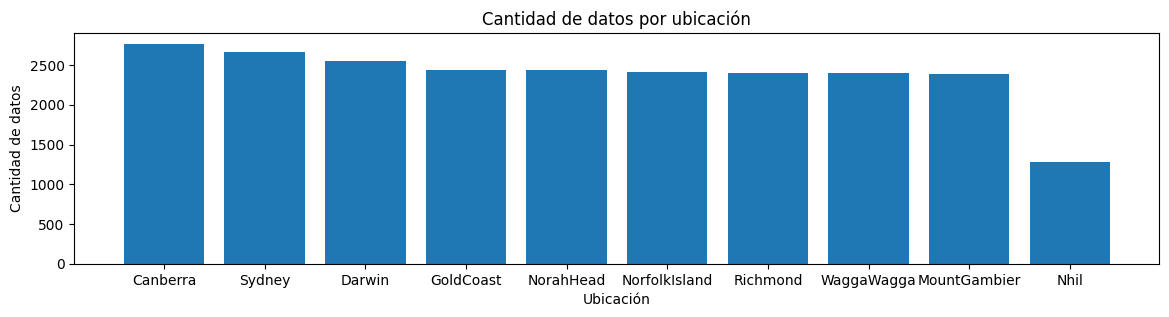

In [64]:
plt.figure(figsize=(14,3))
plt.bar(location_values.index, location_values.values)
plt.xlabel('Ubicación')
plt.ylabel('Cantidad de datos')
plt.title('Cantidad de datos por ubicación')

In [79]:
max_: np.int64 = location_values.values[0] 
penultimo: np.int64 = location_values.values[len(location_values)-2]
dif: np.int64 = max_- penultimo
print(f' La penúltima ubicacion en la tabla tiene un {round(dif*100/max_, 2)}% menos de datos que la primera')

 La penúltima ubicacion en la tabla tiene un 13.69% menos de datos que la primera


In [13]:
object_columns: list[str] = ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']

In [14]:
dummies: pd.DataFrame = pd.get_dummies(X_train, columns=object_columns)

aux = pd.concat([X_train.drop(object_columns, axis=1), dummies], axis=1)

chequeamos que efectivamente se hayan dropeado las columnas object.

In [15]:
for column in object_columns:
    if column in aux.columns.tolist():
        print(f'{column} founded')

In [16]:
aux.columns

Index(['Date', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainToday', 'Date', 'MinTemp', 'MaxTemp',
       'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am',
       'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am',
       'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm',
       'RainToday', 'Location_Canberra', 'Location_Darwin',
       'Location_GoldCoast', 'Location_MountGambier', 'Location_Nhil',
       'Location_NorahHead', 'Location_NorfolkIsland', 'Location_Richmond',
       'Location_Sydney', 'Location_WaggaWagga', 'WindGustDir_E',
       'WindGustDir_ENE', 'WindGustDir_ESE', 'WindGustDir_N', 'WindGustDir_NE',
       'WindGustDir_NNE', 'WindGustDir_NNW', 'WindGustDir_NW', 'WindGustDir_S',
       'WindGustDir_SE', 'WindGustDir_SSE', 'WindGustDir_

In [17]:
aux.sample(10)

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,...,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW
22710,2013-08-08,12.1,19.6,0.0,2.8,4.5,37.0,13.0,7.0,79.0,...,False,False,False,False,False,False,False,False,False,False
91594,2012-09-15,12.3,22.8,0.0,NaN,NaN,43.0,28.0,33.0,44.0,...,False,False,False,True,False,False,False,False,False,False
29346,2015-03-19,14.7,32.0,0.0,NaN,NaN,22.0,0.0,11.0,86.0,...,False,False,False,False,False,False,False,False,False,False
102468,2017-04-02,9.6,18.0,0.0,NaN,NaN,43.0,7.0,26.0,76.0,...,False,False,True,False,False,False,False,False,False,False
139717,2010-02-27,22.7,29.1,131.4,NaN,0.0,126.0,31.0,33.0,95.0,...,False,False,False,False,False,False,False,False,True,False
22796,2013-11-02,14.4,20.3,1.4,6.4,9.3,31.0,15.0,19.0,58.0,...,False,False,False,False,False,False,False,False,False,False
46695,2010-11-13,13.0,27.7,0.0,5.2,8.9,46.0,7.0,17.0,62.0,...,True,False,False,False,False,False,False,False,False,False
101834,2015-07-08,8.2,13.8,0.0,0.6,4.1,31.0,13.0,13.0,93.0,...,True,False,False,False,False,False,False,False,False,False
45847,2008-07-18,1.3,10.6,0.0,0.8,5.6,46.0,24.0,33.0,75.0,...,False,False,False,False,False,False,False,False,True,False
74277,2015-07-24,3.9,15.6,0.0,NaN,NaN,57.0,19.0,39.0,100.0,...,False,False,False,False,False,False,False,False,True,False


Visualizamos nulos.

In [18]:
X_train.isna().sum()

Date                 0
Location             0
MinTemp             63
MaxTemp             55
Rainfall           249
Evaporation       9245
Sunshine         11161
WindGustDir       1430
WindGustSpeed     1424
WindDir9am        1542
WindDir3pm         419
WindSpeed9am       325
WindSpeed3pm       305
Humidity9am        180
Humidity3pm        125
Pressure9am        268
Pressure3pm        259
Cloud9am          9684
Cloud3pm          9842
Temp9am             95
Temp3pm             83
RainToday            0
dtype: int64

In [19]:
numerical_float_columns: list[str] = X_train.select_dtypes(include=[np.number, 'float']).columns.to_list()

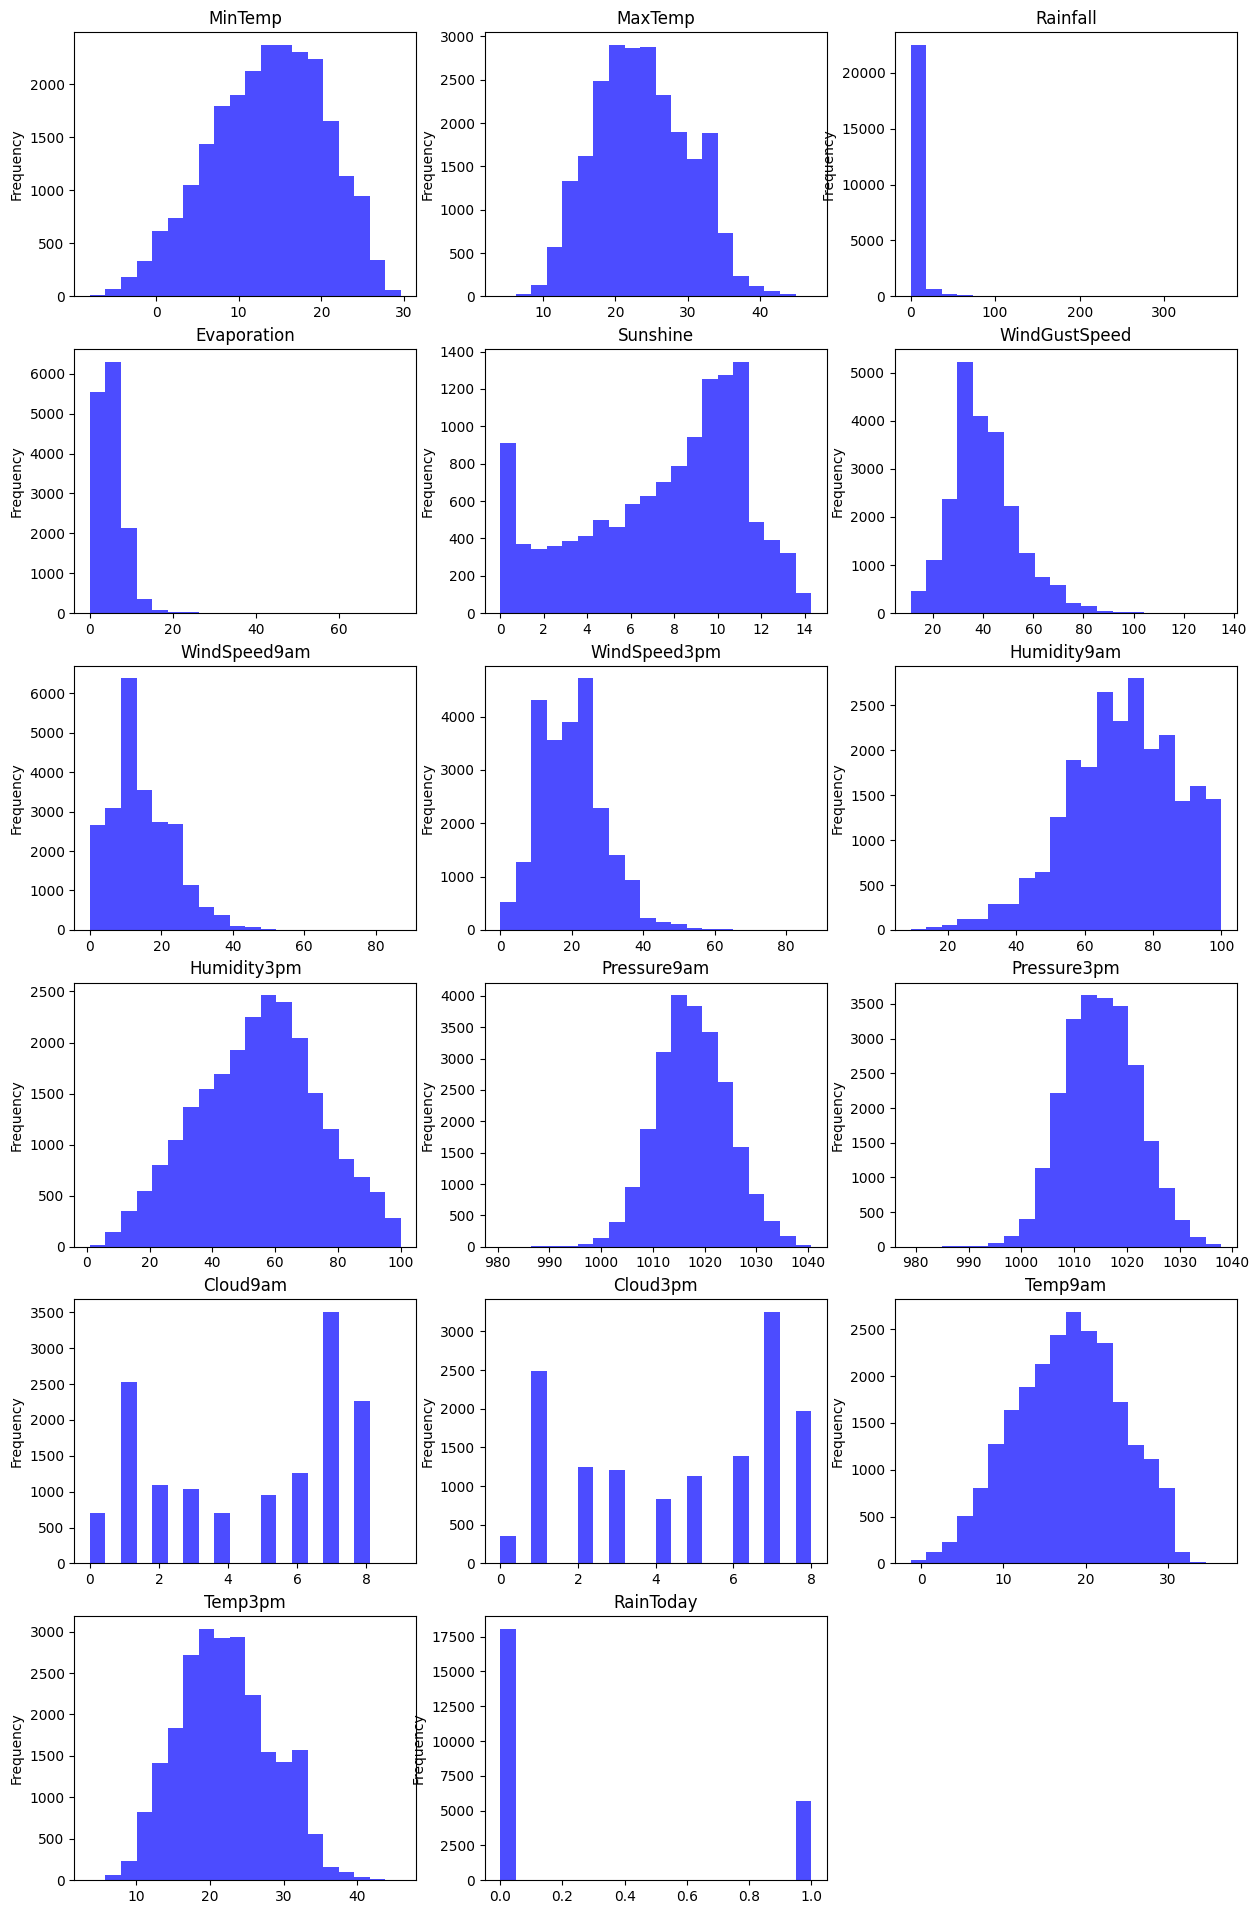

In [20]:
num_columns = 3  # Number of columns per row
num_rows = (len(numerical_float_columns) + num_columns - 1) // num_columns  # Calculate required rows

# Create a figure with subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(5 * num_columns, 4 * num_rows))

# Flatten axes array for easier iteration
axes = axes.flatten()

# Plot histograms for each numerical column
for ax, col in zip(axes, numerical_float_columns):
    ax.hist(X_train[col], bins=20, color='blue', alpha=0.7)
    ax.set_title(f'{col}')
    #ax.set_xlabel(col)
    ax.set_ylabel('Frequency')

# Hide any unused subplots
for i in range(len(numerical_float_columns), len(axes)):
    fig.delaxes(axes[i])

Observamos que las siguientes distribuciones son **normales**:
 - Temp3pm
 - Temp9am
 - Pressure9am, con una cola pesada hacia la izquierda.
 - Pressure3pm
 - Humidity3pm
 - MinTemp, con una cola pesada hacia la izquierda.
 - WinSpeed9am, con una cola pesada hacia la derecha.

 Hay distribuciones **binomiales**:
  - Cloud9am
  - Cloud3pm

In [21]:
#plt.box(X_train[numerical_float_columns])

In [22]:
#knn_imputer: KNNImputer = KNNImputer(n_neighbors=5)

In [23]:
"""
k_values = [1, 3, 5, 7, 9, 11]
 
# Create subplots for each k value
fig, axes = plt.subplots(1, len(k_values), figsize=(15, 3))
 
# Train and visualize the models with varying k values
for i, k in enumerate(k_values):
    # Create KNN model
    knn = KNNImputer(n_neighbors=k)
 
    # Train the model
    knn.fit(X_train[numerical_float_columns], y_train)
 
    # Make predictions
    y_pred = knn.predict(X_test)
 
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
 
    # Plot decision boundary
    h = 0.02  # Step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
 
    # Plot the decision boundary
    axes[i].contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
 
    # Plot the training points
    axes[i].scatter(X_train[:, 0], X_train[:, 1], c=y_train,
                    edgecolors='k', cmap=plt.cm.Paired)
 
    # Plot the testing points
    axes[i].scatter(X_test[:, 0], X_test[:, 1], c=y_test,
                    marker='x', edgecolors='k', cmap=plt.cm.Paired)
 
    # Set plot labels and title
    axes[i].set_title(f'k={k}, Accuracy={accuracy:.2f}')
    axes[i].set_xlabel('Feature 1')
    axes[i].set_ylabel('Feature 2')
 
plt.show()

"""


"\nk_values = [1, 3, 5, 7, 9, 11]\n \n# Create subplots for each k value\nfig, axes = plt.subplots(1, len(k_values), figsize=(15, 3))\n \n# Train and visualize the models with varying k values\nfor i, k in enumerate(k_values):\n    # Create KNN model\n    knn = KNNImputer(n_neighbors=k)\n \n    # Train the model\n    knn.fit(X_train[numerical_float_columns], y_train)\n \n    # Make predictions\n    y_pred = knn.predict(X_test)\n \n    # Calculate accuracy\n    accuracy = accuracy_score(y_test, y_pred)\n \n    # Plot decision boundary\n    h = 0.02  # Step size in the mesh\n    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1\n    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1\n    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),\n                         np.arange(y_min, y_max, h))\n    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])\n    Z = Z.reshape(xx.shape)\n \n    # Plot the decision boundary\n    axes[i].contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)\n \n    # Plot th